In [1]:
from functions import *
import pandas as pd
import seaborn as sns
import statistics
from matplotlib import pyplot as plt
%matplotlib inline

MODE = 'SSD' # Analysis on SSD or HDD Benchmark Set

GRANULARITY = 5000 # Only work with the last X rows of data sets
blocks = pd.read_csv("./raw_data/{}/data_block.csv".format(MODE), names=["BLOCK", "NS"])

blocks_info = pd.read_csv("./data/enhanced_block.csv", names=["BLOCK", "SIZE", "VERSION", "numberTX", "numberVin", "numberVout", "numberJoinSplit", "numbervShieldedSpend", "numbervShieldedOutput"])

blocks = pd.read_csv("./raw_data/{}/data_block.csv".format(MODE), names=["BLOCK", "BLOCK_NS"])
data_inputs = pd.read_csv("./raw_data/{}/data_ecdsa.csv".format(MODE), names=["BLOCK", "NS"])
data_spends = pd.read_csv("./raw_data/{}/data_shieldedSpend.csv".format(MODE), names=["BLOCK", "NS"])
data_outputs = pd.read_csv("./raw_data/{}/data_shieldedOutput.csv".format(MODE), names=["BLOCK", "NS"])
data_joinSplits = pd.read_csv("./raw_data/{}/data_joinsplit.csv".format(MODE), names=["BLOCK", "NS"])

blocks_info.sort_values(by=['numbervShieldedSpend']).tail()

,BLOCK,SIZE,VERSION,numberTX,numberVin,numberVout,numberJoinSplit,numbervShieldedSpend,numbervShieldedOutput
770802,00000000006f4825f45135e3c0189ed44dcba9b042a4c0...,170864,4,2,1,2,0,438,1
843715,000000000286c8940dfd66422645842034ef10f22a791f...,178107,4,3,6,5,0,452,2
621262,0000000000a6e3e7b13302358231d9756c308f7907c4dd...,187614,4,2,1,3,0,484,0
626889,000000000077cf927f9372008ea343a43549274f339368...,269391,4,9,12,16,0,691,0
619945,0000000000918f062547f7a092bb9933dc75049ef622d0...,267139,4,2,1,3,0,691,0


In [2]:
# Clean data
onlyContainingTransparent = blocks_info.loc[(blocks_info['numberJoinSplit'] == 0) & (blocks_info['numbervShieldedSpend'] == 0) & (blocks_info['numbervShieldedOutput'] == 0)]
# Fix Benchmark errors
blocks = blocks[blocks['BLOCK_NS'] < blocks['BLOCK_NS'].quantile(0.99)] # Remove extreme outliers
# Make sure no transparent tx was recorded 
data_spends = data_spends[~data_spends['BLOCK'].isin(onlyContainingTransparent['BLOCK'])]
data_outputs = data_outputs[~data_outputs['BLOCK'].isin(onlyContainingTransparent['BLOCK'])]
data_joinSplit = data_joinSplits[~data_joinSplits['BLOCK'].isin(onlyContainingTransparent['BLOCK'])]

In [3]:
# Merge Data
block_inputs = data_inputs.merge(blocks, how='inner', left_on="BLOCK", right_on="BLOCK")
block_spends = data_spends.merge(blocks, how='inner', left_on="BLOCK", right_on="BLOCK")
block_outputs = data_outputs.merge(blocks, how='inner', left_on="BLOCK", right_on="BLOCK")
block_joinSplits = data_joinSplits.merge(blocks, how='inner', left_on="BLOCK", right_on="BLOCK")

In [4]:
# Group Data+
block_inputs = group_block(block_inputs)
block_spends = group_block(block_spends)
block_outputs = group_block(block_outputs)
block_joinSplits = group_block(block_joinSplits)

In [5]:
# Whats the median time in % per block of a single operation (Check Input, Check Spend ...)?

In [6]:
# Whats the median time in % per block of the total operations (Check all Inputs, Check all Spends ...)?

In [7]:
#total_mall_sapling = total_percent_of_block(group_by_block(
   # [data_mall_hash,
   # data_mall_bindingSig]), blocks)

#total = total_percent_of_block(group_by_block(
    #[data_ecdsa_checks, 
    #data_shielded_spend, 
    #data_mall_hash, 
    #data_shielded_output, 
    #data_mall_bindingSig,
    #data_joinSplit]), blocks)

In [8]:
color = "muted"
sns.despine(left=True)
color = sns.color_palette(color, 5)
olor_primary = color[0]
color_kb = color[2]
color_r2 = color[3]
color_kv = color[1]
sns.set(style="darkgrid", palette=color, color_codes=True)
sns.despine(left=True)

<Figure size 432x288 with 0 Axes>

In [9]:
blocks["BLOCK_NS"] = blocks["BLOCK_NS"] / 1000

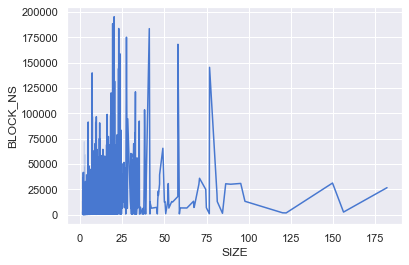

In [10]:
blocks = blocks.merge(blocks_info, how='inner', left_on="BLOCK", right_on="BLOCK")
if GRANULARITY: 
    blocks = blocks.tail(GRANULARITY)

blocks["SIZE"] = blocks["SIZE"] / 1024 # Convert to KB
ax = sns.lineplot(x="SIZE", y="BLOCK_NS", data=blocks)

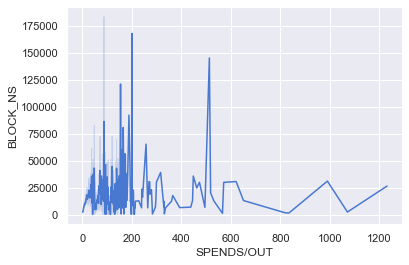

In [11]:
blocks["SPENDS/OUT"] = blocks["numbervShieldedSpend"] + blocks["numbervShieldedOutput"] + blocks['numberVin']
ax = sns.lineplot(x="SPENDS/OUT", y="BLOCK_NS", data=blocks)

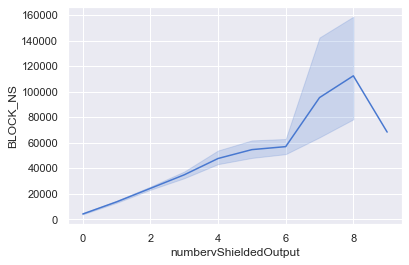

In [12]:
ax = sns.lineplot(x="numbervShieldedOutput", y="BLOCK_NS", data=blocks)

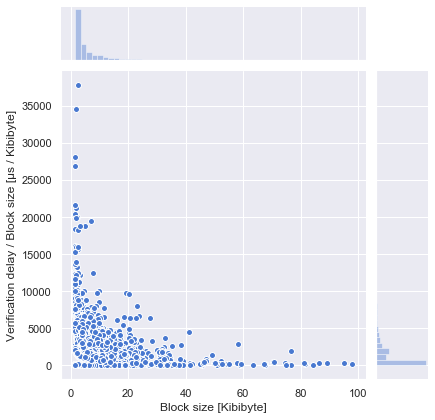

In [13]:
blocks_size = blocks.copy(deep=True)
blocks_size["BLOCK_NS"] = blocks_size["BLOCK_NS"] / blocks_size["SIZE"]
blocks_size = blocks_size[blocks_size["SIZE"] < 100]
blocks_size = blocks_size[blocks_size["BLOCK_NS"] < 40000]

g = sns.jointplot("SIZE", "BLOCK_NS", data=blocks_size, edgecolor="w")
g.set_axis_labels('Block size [Kibibyte]', 'Verification delay / Block size [μs / Kibibyte]')

g.fig.savefig(MODE + "_SIZE.pdf", bbox_inches='tight')

In [14]:
blocks_size.count()

BLOCK                    4994
BLOCK_NS                 4994
SIZE                     4994
VERSION                  4994
numberTX                 4994
numberVin                4994
numberVout               4994
numberJoinSplit          4994
numbervShieldedSpend     4994
numbervShieldedOutput    4994
SPENDS/OUT               4994
dtype: int64

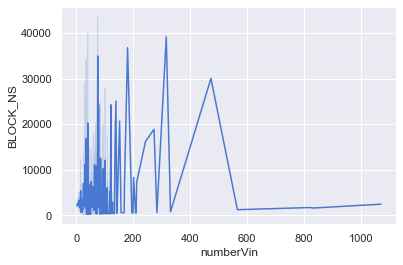

In [15]:
blocks_transparent = blocks.copy(deep=True)
blocks_transparent =  blocks_transparent[blocks_transparent['BLOCK'].isin(onlyContainingTransparent['BLOCK'])]

ax = sns.lineplot(x="numberVin", y="BLOCK_NS", data=blocks_transparent)

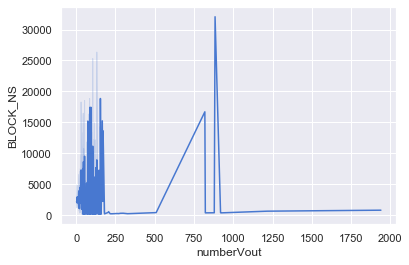

In [16]:
ax = sns.lineplot(x="numberVout", y="BLOCK_NS", data=blocks_transparent)

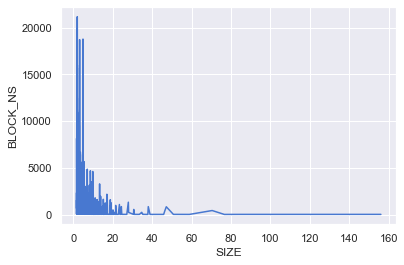

In [17]:
blocks_transparent_size = blocks_transparent.copy(deep=True)
blocks_transparent_size['BLOCK_NS'] = blocks_transparent_size['BLOCK_NS'] / blocks_transparent_size['SIZE']

ax = sns.lineplot(x="SIZE", y="BLOCK_NS", data=blocks_transparent_size)

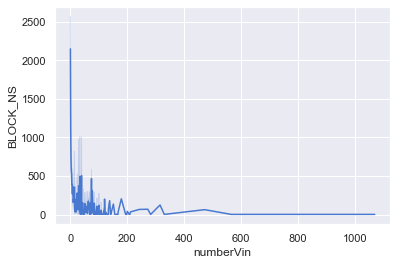

In [18]:
blocks_transparent_in = blocks_transparent.copy(deep=True)
blocks_transparent_in['BLOCK_NS'] = blocks_transparent_in['BLOCK_NS'] / blocks_transparent_in['numberVin']

ax = sns.lineplot(x="numberVin", y="BLOCK_NS", data=blocks_transparent_in)

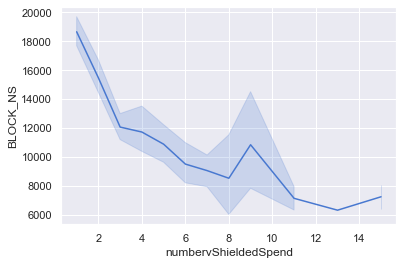

In [19]:
blocks_spend = blocks.copy(deep=True)
blocks_spend = blocks_spend[~blocks_spend['BLOCK'].isin(blocks_transparent['BLOCK'])]
blocks_spend['BLOCK_NS'] = blocks_spend['BLOCK_NS'] / blocks_spend['numbervShieldedSpend']
ax = sns.lineplot(x="numbervShieldedSpend", y="BLOCK_NS", data=blocks_spend)

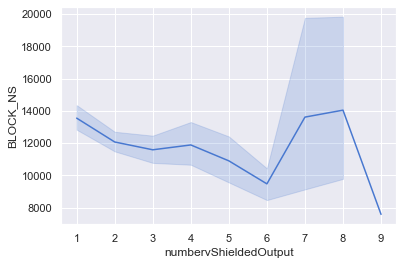

In [20]:
blocks_out = blocks.copy(deep=True)
blocks_out = blocks_out[~blocks_out['BLOCK'].isin(blocks_transparent['BLOCK'])]
blocks_out['BLOCK_NS'] = blocks_out['BLOCK_NS'] / blocks_out['numbervShieldedOutput']
ax = sns.lineplot(x="numbervShieldedOutput", y="BLOCK_NS", data=blocks_out)

In [21]:
blocks_shielded = blocks.copy(deep=True)
blocks_shielded = blocks_shielded[~blocks_shielded['BLOCK'].isin(blocks_transparent['BLOCK'])]
blocks_shielded['SIZE'].count()

1683

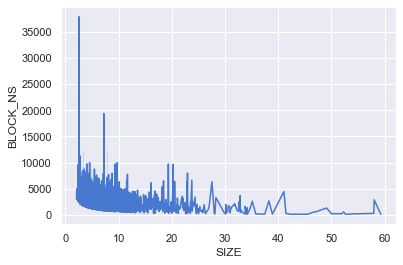

In [22]:
blocks_shielded_size = blocks_shielded.copy(deep=True)
blocks_shielded_size["BLOCK_NS"] = blocks_shielded_size["BLOCK_NS"] / blocks_shielded_size["SIZE"]
blocks_shielded_size = blocks_shielded_size.loc[blocks_shielded_size["SIZE"] < 60]
ax = sns.lineplot(x="SIZE", y="BLOCK_NS", data=blocks_shielded_size)

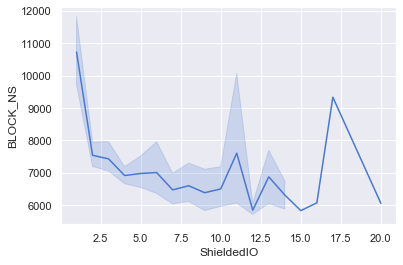

In [23]:
blocks_shielded_combined = blocks_shielded.copy(deep=True)
blocks_shielded_combined['ShieldedIO'] = blocks_shielded_combined['numbervShieldedSpend'] + blocks_shielded_combined['numbervShieldedOutput']
blocks_shielded_combined['BLOCK_NS'] = blocks_shielded_combined['BLOCK_NS'] / blocks_shielded_combined['ShieldedIO']
ax = sns.lineplot(x="ShieldedIO", y="BLOCK_NS", data=blocks_shielded_combined)

In [24]:
blocks_shielded_combined.head()

,BLOCK,BLOCK_NS,SIZE,VERSION,numberTX,numberVin,numberVout,numberJoinSplit,numbervShieldedSpend,numbervShieldedOutput,SPENDS/OUT,ShieldedIO
381178,0000000001e7cfd93f06ad656de31f6756865def5ffebf...,5865.166667,6.880859,4,8,8,22,0,4,2,14,6
381182,0000000001efdee8b0723499593e5de18d60b12399ea61...,7101.500000,3.933594,4,2,1,2,0,1,2,4,3
381184,000000000153dc6dab13efb9ec9c2b468b7c097c55fdb3...,5918.480000,7.903320,4,9,15,23,0,3,2,20,5
381185,00000000008f3866dd47b17ec655da4409d4fd4dd3ef27...,6063.625000,21.028320,4,7,116,17,0,3,1,120,4
381191,00000000008bd20486596cb585be1d3570e56e2eb18198...,5838.066667,20.192383,4,29,51,80,0,11,4,66,15


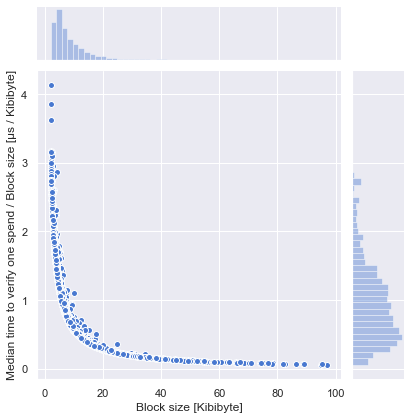

In [25]:
# Shielded Spends influence on size
spend_enriched = block_spends.copy(deep=True)
spend_enriched = spend_enriched.merge(blocks_info, how='inner', left_on="BLOCK", right_on="BLOCK")
spend_enriched['NS_median'] = spend_enriched['NS_median'] / spend_enriched['SIZE']

spend_enriched.NS_median = spend_enriched.NS_median / 1000 # TO MicS
spend_enriched["SIZE"] = spend_enriched["SIZE"] / 1024 # Convert to KiB

spend_enriched = spend_enriched.tail(GRANULARITY)
spend_enriched = spend_enriched[spend_enriched["SIZE"] < 100]

g = sns.jointplot("SIZE", "NS_median", data=spend_enriched, edgecolor="w")
g.set_axis_labels('Block size [Kibibyte]', 'Median time to verify one spend / Block size [μs / Kibibyte]')

g.fig.savefig(MODE + "SPENDS.pdf", bbox_inches='tight')

In [26]:
spend_enriched.sort_values(by=['numbervShieldedSpend']).tail()

,BLOCK,BLOCK_NS,NS_median,NS_sum,SIZE,VERSION,numberTX,numberVin,numberVout,numberJoinSplit,numbervShieldedSpend,numbervShieldedOutput
96462,000000000020e5523ac54df176cc0237b3e26b7122c7c8...,109866400,0.468418,98552600,12.078125,4,9,10,17,0,17,2
96324,00000000003048a7d821ab17c73980ea6304adf91e15e8...,155921100,0.366013,119726000,15.179688,4,14,14,24,1,21,1
96099,00000000005590cad7ddd8b52b330f43468d5e29de0691...,149422901,0.292642,127110701,19.238281,4,12,14,103,0,22,4
95972,000000000063e6cd826da5933fd5c5f9ff6061a731aa65...,157656702,0.373902,146240702,15.180664,4,8,13,13,0,25,2
95954,000000000015c8aa25cd0871579d3d79898b65ef181374...,191445602,0.268298,185062802,21.310547,4,10,26,99,0,31,1


In [27]:
# Shielded Outputs influence on size
outputs_enriched = block_outputs.copy(deep=True)
outputs_enriched = outputs_enriched.merge(blocks_info, how='inner', left_on="BLOCK", right_on="BLOCK")

g = sns.jointplot("SIZE", "NS_median", data=inputs_enriched, edgecolor="w")
g.set_axis_labels('Block size [Kibibyte]', 'Median time to verify one input / Block size [ns / Kibibyte]')

g.fig.savefig(MODE + "INPUTS.pdf", bbox_inches='tight')
outputs_enriched['NS_median'] = outputs_enriched['NS_median'] / outputs_enriched['SIZE']

outputs_enriched.NS_median = outputs_enriched.NS_median / 1000 # TO MicS
outputs_enriched["SIZE"] = outputs_enriched["SIZE"] / 1024 # Convert to KiB

outputs_enriched = outputs_enriched.tail(GRANULARITY)
outputs_enriched = outputs_enriched[outputs_enriched["SIZE"] < 100]

g = sns.jointplot("SIZE", "NS_median", data=outputs_enriched, edgecolor="w")
g.set_axis_labels('Block size [Kibibyte]', 'Median time to verify one output / Block size [μs / Kibibyte]')

g.fig.savefig(MODE + "OUTPUTS.pdf", bbox_inches='tight')

NameError: name 'inputs_enriched' is not defined

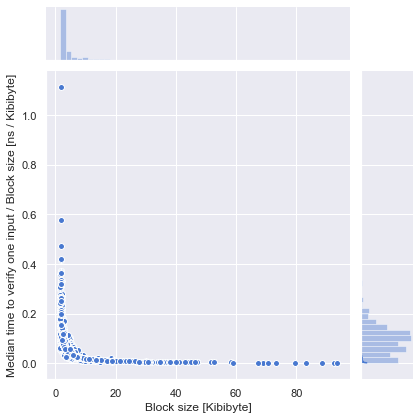

In [28]:
inputs_enriched = block_inputs.copy(deep=True)
inputs_enriched = inputs_enriched.merge(blocks_info, how='inner', left_on="BLOCK", right_on="BLOCK")
inputs_enriched = inputs_enriched[inputs_enriched['BLOCK'].isin(onlyContainingTransparent['BLOCK'])] # Sanity Check :)

inputs_enriched['NS_median'] = inputs_enriched['NS_median'] / inputs_enriched['SIZE']

#inputs_enriched.NS_median = inputs_enriched.NS_median / 1000 # TO MicS
inputs_enriched["SIZE"] = inputs_enriched["SIZE"] / 1024 # Convert to KiB

inputs_enriched = inputs_enriched.tail(GRANULARITY)
inputs_enriched = inputs_enriched[inputs_enriched["SIZE"] < 100]
inputs_enriched = inputs_enriched[inputs_enriched["NS_median"] < 2]

g = sns.jointplot("SIZE", "NS_median", data=inputs_enriched, edgecolor="w")
g.set_axis_labels('Block size [Kibibyte]', 'Median time to verify one input / Block size [ns / Kibibyte]')

g.fig.savefig(MODE + "INPUTS.pdf", bbox_inches='tight')
ax = sns.lineplot(x="SIZE", y="NS_median", data=inputs_enriched)

In [29]:
inputs_enriched.count()

BLOCK                    4994
BLOCK_NS                 4994
NS_median                4994
NS_sum                   4994
SIZE                     4994
VERSION                  4994
numberTX                 4994
numberVin                4994
numberVout               4994
numberJoinSplit          4994
numbervShieldedSpend     4994
numbervShieldedOutput    4994
dtype: int64

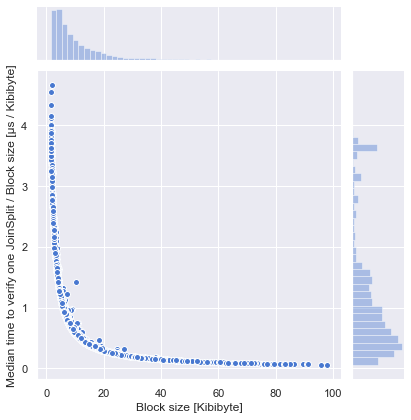

In [30]:
# JoinSplit influence on size
js_enriched = block_joinSplits.copy(deep=True)
js_enriched = js_enriched.merge(blocks_info, how='inner', left_on="BLOCK", right_on="BLOCK")
js_enriched['NS_median'] = js_enriched['NS_median'] / js_enriched['SIZE']

js_enriched.NS_median = js_enriched.NS_median / 1000 # TO MicS
js_enriched["SIZE"] = js_enriched["SIZE"] / 1024 # Convert to KiB

js_enriched = js_enriched.tail(GRANULARITY)
js_enriched = js_enriched[js_enriched["SIZE"] < 100]

g = sns.jointplot("SIZE", "NS_median", data=js_enriched, edgecolor="w")
g.set_axis_labels('Block size [Kibibyte]', 'Median time to verify one JoinSplit / Block size [μs / Kibibyte]')

g.fig.savefig(MODE + "JS.pdf", bbox_inches='tight')